In [1]:
import torch
from torch import nn
from torch import Tensor
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hardware Hyperparameters
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = 'cpu' # makes everything easier in general

In [10]:
# Parameters
Nin = 1   # Inputs
Nout = 1  # Outputs
Nhid = 8  # Nodes
                           
n_samples = 1000                   # Mesh division

train_a = -5                       # Mesh lower limit
train_b = 5                        # Mesh upper limit

h = (train_b - train_a)/n_samples  # Mesh parameter "h"

mu = 0                 # Mu for the initialization of X
sigma0 = 2             # Sigma for the initialization of X
sigma1 = 3             # Sigma to propose new x in the Metropolis-Hastings algorithm

stepsMH = 10           # Number of steps done in the Metropolis-Hastings algorithm for each epoch

Q_train = torch.linspace(train_a,train_b,n_samples, requires_grad=True)   # X mesh equivalently distributed
target = (1/np.pi)**(1/4) * torch.exp(-Q_train*Q_train/2)                 # HO analytical solution (phi(x))
target = target.clone().detach()

In [11]:
class HarmonicNN(nn.Module):
    def __init__(self):
        super(HarmonicNN, self).__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(Nin,Nhid,bias=True)   # shape = (Nhid,Nin)
        self.actfun = nn.Sigmoid()                 # activation function
        self.lc2 = nn.Linear(Nhid,Nout,bias=False) # shape = (Nout,Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

In [12]:
# Function to initialize the X tensor and its correspondent probability, P_X, according to an exponential(mu, sigma_0)
def sampler():
    sample = []
    p_sample = []
    for j in range(n_samples):
        x = np.random.normal(mu, sigma0)
        y = np.exp(-(x-mu)**2/(2*sigma0**2))/np.sqrt(2*np.pi*sigma0**2)
        sample.append(x)
        p_sample.append(y)
    sample = torch.tensor(sample, requires_grad=True)
    p_sample = torch.tensor(p_sample)
    return sample, p_sample

In [13]:
# Function to calculate the norm of phi(x)
def norm(Q_train, a):
    X = Q_train.clone().unsqueeze(1)
    y = net(X)
    f_x = torch.exp(-X*X*a)
    phi_t = y * f_x
    
    N = h * torch.sum(phi_t * phi_t)
    return N

In [14]:
# Function with the Metropolis-Hastings algorithm. It returns the new X and new P_X tensors.
def MetropolisHastings(x, p_x, N, a):
    p_x = p_x * N
    x = x.detach().numpy()
    p_x = p_x.detach().numpy()
    for i in range(stepsMH):
        x_old = x
        p_old = p_x
        x_new = np.random.normal(x, sigma1)
        x_new = x_new.astype('float32')
        
        X = torch.tensor(x_new)
        X = X.clone().unsqueeze(1)
        phi = net(X)
        phi = phi.detach().numpy()
        
        f_x = np.exp(-x_new*x_new*a)
        f_x = np.expand_dims(f_x, axis=1)
        phi_t = phi*f_x
        p_new = phi_t*phi_t
        
        alpha = p_new/p_x
        u = np.random.rand(n_samples,1)
        
        acceptance = 0
        for j in range(n_samples):  
            if u[j] <= alpha[j] and abs(x_new[j]) < 6:
                x[j] = x_new[j]
                p_x[j] = p_new[j]
                acceptance = acceptance + 1
        if acceptance>50:
            x = x_old
            p_x = p_old
            acceptance = 0

    x = torch.tensor(x, requires_grad=True)
    p_x = torch.tensor(p_x, requires_grad=True)
    return x, p_x

In [15]:
# Function to plot the wavefunction and the energy cost function evolution
def pic(i, x, y, loss, error):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.set_title("Epoch {}".format(i+1))
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$\psi(x)$")
    ax1.plot(x.detach().numpy(), y.detach().numpy(), 'r.', label='$\psi_{NN}$')
    ax1.plot(Q_train.detach().numpy(), target.detach().numpy(), label='$\psi_{target}$')
    ax1.legend()
    ax2.set_title("Loss Function")
    plt.subplots_adjust(wspace=0.2)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Cost")
    ax2.plot(torch.linspace(1, i+1, i+1).numpy(), loss.detach().numpy(),label='$E$')
    ax2.plot(torch.linspace(1, i+1, i+1).numpy(), torch.ones(i+1).numpy()-0.5,'--',label='$E_0$')
    ax2.fill_between(torch.linspace(1, i+1, i+1).numpy(), loss.detach().numpy()-error.detach().numpy(), loss.detach().numpy()+error.detach().numpy(), alpha=0.2)
    ax2.set_ylim(0.45,0.8)
    # inset axes....
    axins = ax2.inset_axes([0.4, 0.5, 0.5, 0.1])
    axins.plot(torch.linspace(1, i+1, i+1).numpy(), loss.detach().numpy(),label='$E$')
    axins.plot(torch.linspace(1, i+1, i+1).numpy(), torch.ones(i+1).numpy()-0.5,'--',label='$E_0$')
    axins.fill_between(torch.linspace(1, i+1, i+1).numpy(), loss.detach().numpy()-error.detach().numpy(), loss.detach().numpy()+error.detach().numpy(), alpha=0.2)
    # sub region of the original image
    x1, x2, y1, y2 = i-200, i+2, 0.495, 0.505
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    #axins.set_xticklabels([])
    #axins.set_yticklabels([])
    ax2.indicate_inset_zoom(axins, edgecolor="black")
    ax2.legend() 
    plt.show()

The ENVELOPE works like:

A new COST FUNCTION is needed.

$\psi (x) = \phi_{NN}(x) \cdot f(x) \\$
$\frac{d^2 \psi(x)}{dx^2} = \frac{d^2 \phi_{NN}(x)}{dx^2} \cdot f(x) + 2 \cdot \frac{d \phi_{NN}(x)}{dx} \cdot \frac{d f(x)}{dx} + \phi_{NN}(x) \cdot \frac{d^2 f(x)}{dx^2}$

where:

$f(x) = e^{-ax^2}\\
f'(x) = -2axe^{-ax^2}\\
f''(x) = (4x^2-2)e^{-ax^2}$

In [18]:
# Function tha calculates the energy cost function. Here is also applied the envelope to the output of the ANN

def cost(X, p_X, a):
    y = torch.zeros(n_samples)    
    y_1 = torch.zeros(n_samples)
    y_2 = torch.zeros(n_samples)
    
    X = X.clone().unsqueeze(1)
    
    y = net(X)    
    first_der, = grad(outputs=y, grad_outputs=torch.ones_like(y), inputs=X, create_graph=True)                     # First order derivative
    second_der, = grad(outputs=first_der, grad_outputs=torch.ones_like(first_der), inputs=X, create_graph=True)    # Second order derivative
    
    phi = y
    d_phi_dx = first_der.clone()
    d2_phi_d2x = second_der.clone()
    
    f_x = torch.exp(-X*X*a)
    df_x = -2*a*X*torch.exp(-X*X*a)
    d2f_x = (4*a*a*X*X-2*a)*torch.exp(-X*X*a)
    
    phi_t = phi * f_x
    d2_phi_t = d2_phi_d2x * f_x + 2 * d_phi_dx * df_x + phi * d2f_x
    
    N = torch.sum(phi_t ** 2 / p_X) / n_samples
    E_local = (-d2_phi_t / phi_t + X*X) / 2              # Local energy 
    E_e = torch.sum(E_local * phi_t**2 / p_X) / n_samples  
    E = E_e / N
    
    error = (E_local - E)**2 * phi_t**2 / p_X / n_samples
    error_tot = torch.sum(error / N)
    N_phi = norm(Q_train, a)
    phi_t = phi_t / torch.sqrt(N_phi)
    
    return E, phi_t, N_phi, error_tot

NN architecture:
 HarmonicNN(
  (lc1): Linear(in_features=1, out_features=8, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=8, out_features=1, bias=False)
)


Loading...:   8%|██▎                         | 247/3000 [00:05<00:55, 49.36it/s]

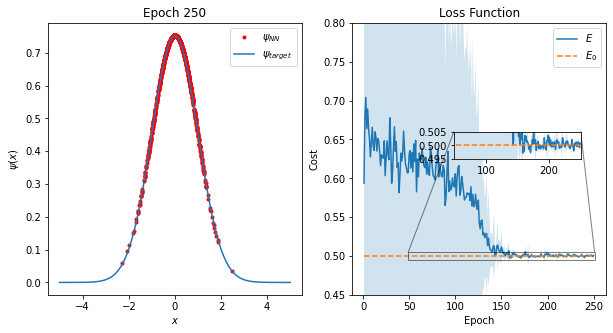

Loading...:  17%|████▋                       | 498/3000 [00:10<00:51, 48.94it/s]

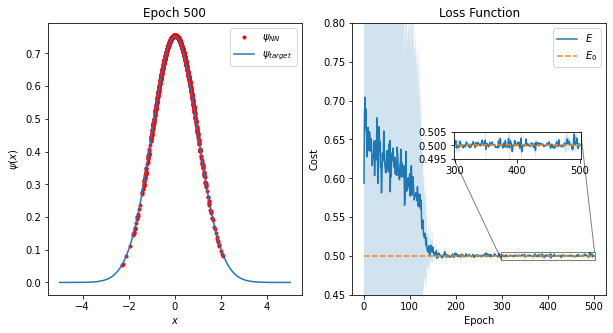

Loading...:  25%|██████▉                     | 745/3000 [00:15<00:45, 49.42it/s]

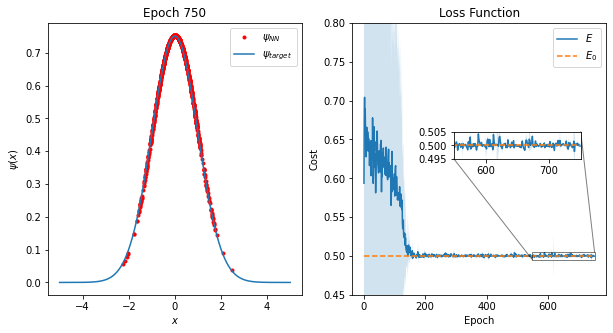

Loading...:  33%|█████████▎                  | 995/3000 [00:21<01:30, 22.06it/s]

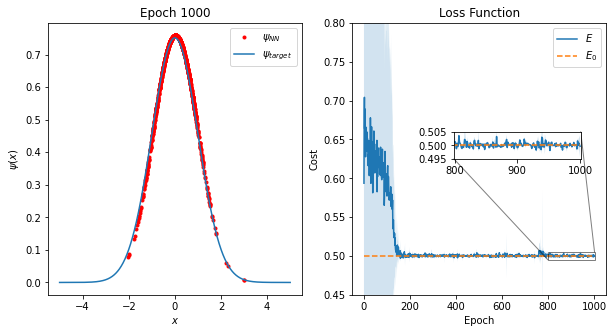

Loading...:  42%|███████████▏               | 1249/3000 [00:27<00:36, 48.50it/s]

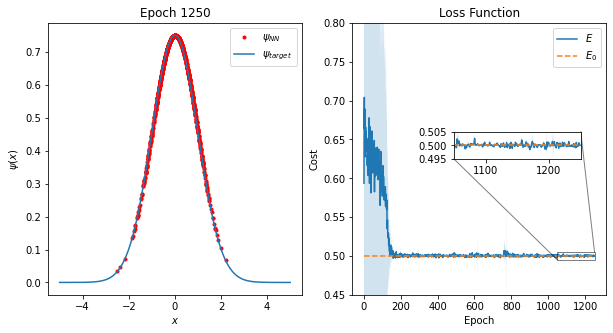

Loading...:  50%|█████████████▍             | 1497/3000 [00:32<00:30, 49.51it/s]

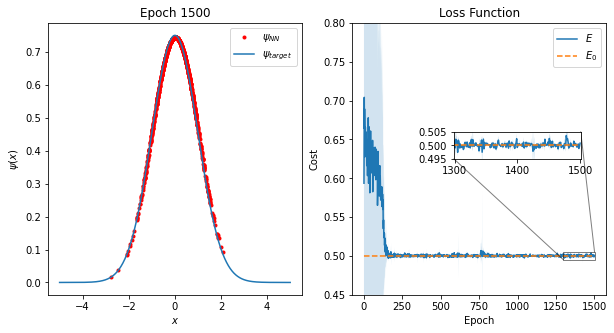

Loading...:  58%|███████████████▋           | 1747/3000 [00:37<00:25, 49.49it/s]

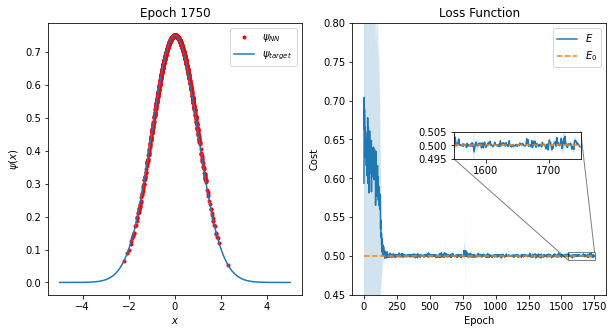

Loading...:  67%|█████████████████▉         | 1999/3000 [00:42<00:20, 49.57it/s]

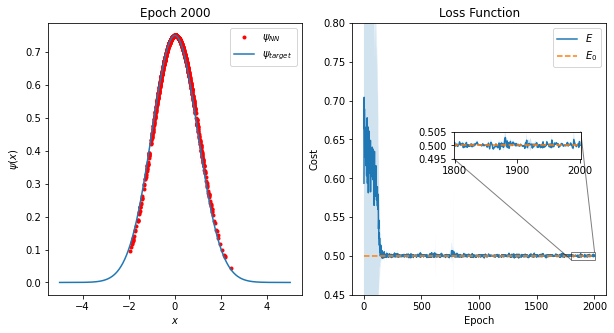

Loading...:  75%|████████████████████▏      | 2248/3000 [00:48<00:15, 49.51it/s]

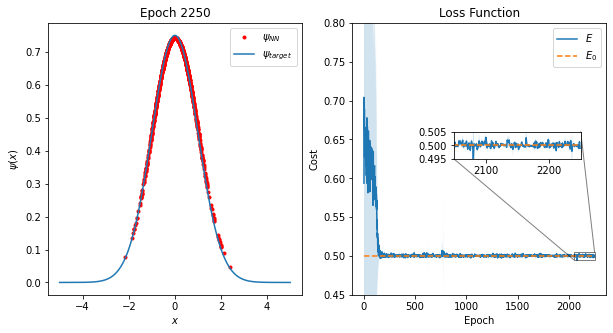

Loading...:  83%|██████████████████████▍    | 2495/3000 [00:53<00:10, 49.57it/s]

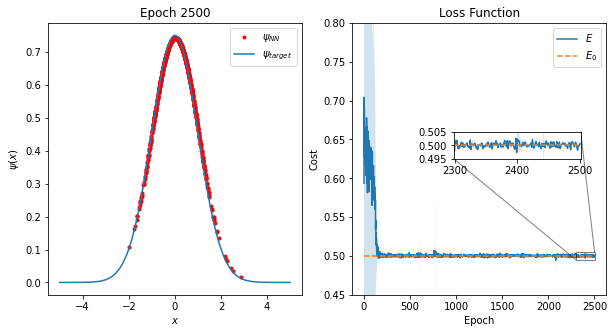

Loading...:  92%|████████████████████████▋  | 2748/3000 [00:58<00:05, 49.36it/s]

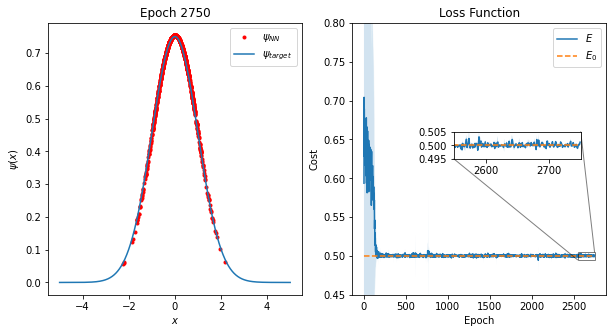

Loading...: 100%|██████████████████████████▉| 2996/3000 [01:04<00:00, 48.56it/s]

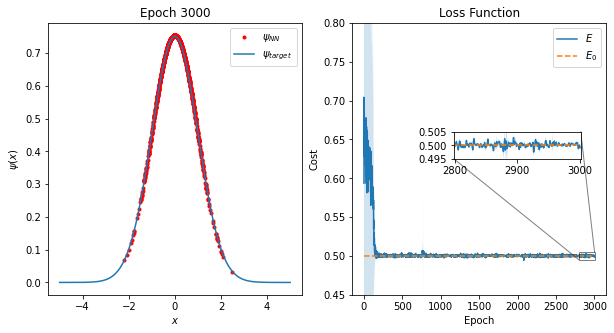

Loading...: 100%|███████████████████████████| 3000/3000 [01:04<00:00, 46.46it/s]


In [19]:
tot_loss = []
tot_error = []

epochs = 3000       # Number of epochs the minimization process will have
lr = 1e-2           # Learning rate
a = 1/4             # This is the parameter of the envelope explained before

W1 = torch.rand(Nhid, Nin, requires_grad=True) * (-1.) # First set of coefficients. Shape = (nodes, Nin)
B = torch.rand(Nhid, requires_grad=False) * 2. - 1.    # Set of bias parameters
W2 = torch.rand(Nout, Nhid, requires_grad=True)        # Second set of coefficients. Shape = (Nout, nodes)

# We load our model to the GPU (or CPU)
net = HarmonicNN().to(device)                          # Initialize the ANN
print("NN architecture:\n",net)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # Algorithm used to optimize the weights

X, p_X = sampler()                                     # Initialize the X and P_X tensor

for i in tqdm(range (epochs), desc="Loading..."):
    if i>0:
        X, p_X = MetropolisHastings(X, phi**2, N, a)   # Does the Metropolis-Hastings algorithm
    
    loss, phi, N, error = cost(X, p_X, a)              # Energy and \phi(x) calculation
    
    optimizer.zero_grad()                              # initialize gradients
    loss.backward()                                    # computation of the gradients
    optimizer.step()                                   # update of the parameters
    
    loss, phi, N, error = cost(X, p_X, a)              # Calculates the energy and \phi(x) again after the optimization
    tot_loss.append(loss)                              # Saves the energy
    tot_error.append(error)                            # Saves the error associated to the energy
    
    if (i+1) % 250 == 0:
        tot_loss1 = torch.stack(tot_loss)
        tot_error1 = torch.stack(tot_error)
        pic(i, X, phi, tot_loss1, tot_error1)          # Plots the figures 

In [20]:
E_t = tot_loss1.detach().numpy()                  # Converts the energy tensor into numpy array
error_t = tot_error1.detach().numpy()             # Converts the error tensor into numpy array

N = 2000                                          # Number of last epochs to take into account when averaging the energy

E_t = E_t[-N:]                                    # Selects the N last components of the energy array
error_t = error_t[-N:]                            # Selects the N last components of the error array

E_m = sum(E_t) / N                                # Averages the N last components of the energy array
error_m = sum(error_t) / N                        # Averages the N last components of the error array, this erro comes from the integration method
error_stat = np.sqrt(sum((E_t - E_m)**2) / N)     # Calculates the error coming from statistics
error_def = np.sqrt(error_m**2 + error_stat**2)   # Quadrature of both errors, from integration methods and statistics

print('E_m = %f +- %f' % (E_m, error_def))
print('error_MC = %f' % (error_m))
print('error_stat = %f' % (error_stat))

E_m = 0.500176 +- 0.001079
error_MC = 0.000698
error_stat = 0.000823
